In [1]:

import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image

In [2]:
# Applying Transforms to the Data
image_transforms = { 
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [3]:
# Load the Data

# Set train and valid directory paths

dataset = ''

train_directory = os.path.join(dataset, 'train_theme')
valid_directory = os.path.join(dataset, 'valid_theme')
test_directory = os.path.join(dataset, 'test_theme')

# Batch size
bs = 32

# Number of classes
num_classes = len(os.listdir(valid_directory))-1  #10#2#257
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid']),
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=bs, shuffle=True)
valid_data_loader = DataLoader(data['valid'], batch_size=bs, shuffle=True)
test_data_loader = DataLoader(data['test'], batch_size=bs, shuffle=True)

7
{0: 'animals', 1: 'art', 2: 'fantasy', 3: 'food', 4: 'landscape', 5: 'licensed', 6: 'towns_and_cities'}


In [4]:
train_data_size, valid_data_size, test_data_size

(384, 131, 129)

In [5]:
# Load pretrained ResNet50 Model
resnet50 = models.resnet50(pretrained=True)
# resnet50 = resnet50.to('cuda:0')


In [6]:
# Freeze model parameters
for param in resnet50.parameters():
    param.requires_grad = False

In [7]:
# Change the final layer of ResNet50 Model for Transfer Learning
fc_inputs = resnet50.fc.in_features

resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_classes), # Since 10 possible outputs
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)

# Convert model to be used on GPU
# resnet50 = resnet50.to('cuda:0')


In [8]:
# Define Optimizer and Loss Function
loss_func = nn.NLLLoss()
optimizer = optim.Adam(resnet50.parameters())

In [9]:
def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_data_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(valid_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/valid_data_size 
        avg_valid_acc = valid_acc/valid_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, dataset+'_theme_model_'+str(epoch)+'.pt')
            
    return model, history
    

In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Print the model to be trained
#summary(resnet50, input_size=(3, 224, 224), batch_size=bs, device='cuda')

# Train the model for 25 epochs
num_epochs = 20
trained_model, history = train_and_validate(resnet50, loss_func, optimizer, num_epochs)

torch.save(history, dataset+'_history.pt')

Epoch: 1/20
Epoch : 000, Training: Loss: 1.7178, Accuracy: 34.8958%, 
		Validation : Loss : 1.3475, Accuracy: 54.1985%, Time: 134.0485s
Epoch: 2/20
Epoch : 001, Training: Loss: 1.2531, Accuracy: 54.9479%, 
		Validation : Loss : 1.0780, Accuracy: 64.8855%, Time: 132.1157s
Epoch: 3/20
Epoch : 002, Training: Loss: 1.0840, Accuracy: 65.8854%, 
		Validation : Loss : 0.9242, Accuracy: 68.7023%, Time: 132.9838s
Epoch: 4/20
Epoch : 003, Training: Loss: 0.9564, Accuracy: 66.9271%, 
		Validation : Loss : 0.9232, Accuracy: 63.3588%, Time: 137.2286s
Epoch: 5/20
Epoch : 004, Training: Loss: 0.9150, Accuracy: 68.4896%, 
		Validation : Loss : 0.8002, Accuracy: 72.5191%, Time: 136.3103s
Epoch: 6/20
Epoch : 005, Training: Loss: 0.7701, Accuracy: 74.4792%, 
		Validation : Loss : 0.8243, Accuracy: 69.4656%, Time: 137.1326s
Epoch: 7/20
Epoch : 006, Training: Loss: 0.7568, Accuracy: 73.1771%, 
		Validation : Loss : 0.8393, Accuracy: 71.7557%, Time: 137.5933s
Epoch: 8/20
Epoch : 007, Training: Loss: 0.6973,

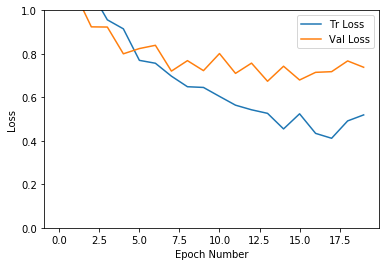

In [36]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.savefig(dataset+'_loss_curve.png')
plt.show()


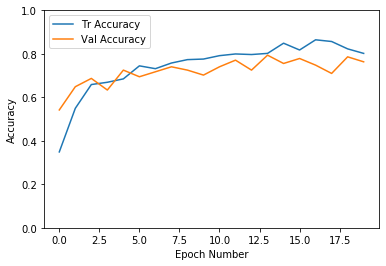

In [37]:
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig(dataset+'_accuracy_curve.png')
plt.show()

In [10]:
 def computeTestSetAccuracy(model, loss_criterion):
    '''
    Function to compute the accuracy on the test set
    Parameters
        :param model: Model to test
        :param loss_criterion: Loss Criterion to minimize
    '''

    device = "cpu"#torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    test_acc = 0.0
    test_loss = 0.0
    
    all_predictions = []

    # Validation - No gradient tracking needed
    with torch.no_grad():

        # Set to evaluation mode
        model.eval()

        # Validation loop
        for j, (inputs, labels) in enumerate(test_data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Compute the total loss for the batch and add it to valid_loss
            test_loss += loss.item() * inputs.size(0)

            # Calculate validation accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            all_predictions.append(predictions)

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to valid_acc
            test_acc += acc.item() * inputs.size(0)

            print("Test Batch number: {:03d}, Test: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

    # Find average test loss and test accuracy
    avg_test_loss = test_loss/test_data_size 
    avg_test_acc = test_acc/test_data_size

    print("Test accuracy : " + str(avg_test_acc))
    return all_predictions


In [11]:
def predict(model, test_image_name,silent=False,return_scores=False):
    '''
    Function to predict the class of a single test image
    Parameters
        :param model: Model to test
        :param test_image_name: Test image

    '''
    
    transform = image_transforms['test']

    test_image = Image.open(test_image_name)
    plt.imshow(test_image)
    
    test_image_tensor = transform(test_image)

    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224)
    
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
        ps = torch.exp(out)
        topk, topclass = ps.topk(3, dim=1)
        if not silent:
            for i in range(3):
                print("Prediction", i+1, ":", idx_to_class[topclass.cpu().numpy()[0][i]], ", Score: ", topk.cpu().numpy()[0][i])
        top_classes = topclass.cpu().numpy()[0]
        top_scores = topk.cpu().numpy()[0]
    if return_scores:
        return [top_classes,top_scores]
    else:
        return top_classes[0]


In [12]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(conf_matrix,cats=[],save=False,
                         cmap=plt.cm.Blues):
    n_classes = len(cats)
    
    # Format the class names
    class_names = [c.replace('_',' ') for c in cats]
    
    plt.clf()
    plt.imshow(conf_matrix,cmap=cmap)
    fmt = '.2f'
    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            if conf_matrix[i,j] > thresh:
                col = "white"
            else:
                col = 'black'
            
            plt.gca().text(j, i, format(conf_matrix[i, j], fmt),
                    ha="center", va="center",color=col)
    plt.xticks(np.arange(n_classes),class_names,rotation=45,ha='right')
    plt.yticks(np.arange(n_classes),class_names)
    plt.xlim(-0.5,n_classes-0.5)
    plt.ylim(n_classes-0.5,-0.5)
    plt.ylabel('True label')
    plt.xlabel('Predicted')
    plt.tight_layout()
    #
    if save:
        plt.savefig(save,dpi=300)
    plt.show()

Prediction 1 : towns_and_cities , Score:  0.6014114
Prediction 2 : landscape , Score:  0.1704571
Prediction 3 : licensed , Score:  0.15047163
[array([6, 4, 5]), array([0.6014114 , 0.1704571 , 0.15047163], dtype=float32)]


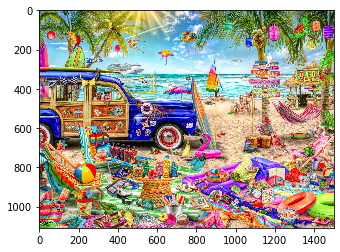

In [13]:
# Test a particular model on a test image

dataset = ''
model = torch.load('_theme_model_13.pt')
x = predict(model, 'new_ims/27.jpg',silent=False,return_scores=True)
print(x)
# Load Data from folders
# all_predictions = computeTestSetAccuracy(model, loss_func)
        
        

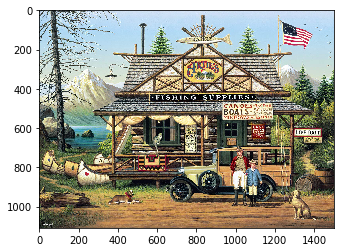

In [14]:
# Do the predictions for the whole dataset
import glob

# cats = ['abstract','collage','hand','photo']
cats = ['animals','art','fantasy','food','landscape','licensed','towns_and_cities']
n_classes = len(cats)

y_preds = []
y_train = []
model = torch.load('models/best_model_theme_7cat.pt')
n_classes = len(idx_to_class.keys())
cats = [idx_to_class[ix] for ix in range(n_classes)]
for ix,wdir in enumerate(cats):
    ims = []
    ims.extend(glob.glob('valid_theme/'+wdir+'/*.jpg'))
    ims.extend(glob.glob('test_theme/'+wdir+'/*.jpg'))
    ims.extend(glob.glob('storage_theme/'+wdir+'/*.jpg'))
    for im in ims[:50]:
        y_preds.append(predict(model, im,silent=True))
        y_train.append(ix)
#         pass
#     print(len(ims))

In [15]:
print(y_preds[0:20])
print(y_train[0:20])
print(np.max(y_preds),np.min(y_preds))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
6 0


Accuracy: 0.7521367521367521


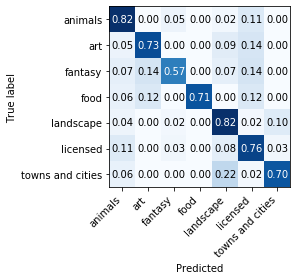

F1 score: 0.7454099123634563


In [16]:
# Make a confusion matrix
from sklearn.metrics import accuracy_score, confusion_matrix,f1_score

print('Accuracy:',accuracy_score(y_train,y_preds))
# And a confusion matrix
conf_matrix = confusion_matrix(y_train,y_preds)
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot it
plot_confusion_matrix(conf_matrix,cats=cats)#,save='conf_matrix.png'

# What is the F1 score?
print('F1 score:',f1_score(y_train,y_preds,average='macro'))

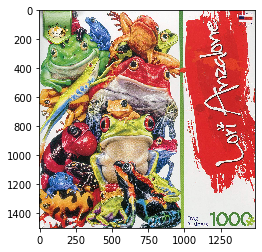

In [129]:
# Do the predictions for the whole dataset of images
import glob,shutil

y_preds = []
y_train = []
model = torch.load('_model_11.pt')
n_classes = len(idx_to_class.keys())
cats = [idx_to_class[ix] for ix in range(n_classes)]

ims = glob.glob('new_ims/*.jpg')

for ix,im in enumerate(ims[0:1000]):
    cat_pred = predict(model, im,silent=True)
    new_fn = 'new_ims/'+cats[cat_pred]+'/'+im.split('/')[-1]
    shutil.move(im,new_fn)

In [176]:
clean_df = pd.read_csv('../clean_product_df.csv')

In [2]:
# Do the predictions for the whole dataset of clean data!
import pandas as pd
import glob,shutil

clean_df = pd.read_csv('../clean_product_df.csv')

y_preds = []
y_train = []
model = torch.load('models/best_model_theme_7cat.pt')

n_classes = len(idx_to_class.keys())
cats = [idx_to_class[ix] for ix in range(n_classes)]

cat_preds = []
for ix in range(clean_df.shape[0])[0:5]:
    prod_ix = clean_df['product_index'][ix]
    ims = glob.glob('*/*/'+str(prod_ix-1)+'.jpg')
    ims.extend(glob.glob('*/'+str(prod_ix-1)+'.jpg'))
    
    if len(ims) < 1:
        print('Didnt find image:',prod_ix,'for puzzle',clean_df['name'][ix])
        cat_preds
        continue
    im = ims[0]
    
    cat_pred = predict(model, im,silent=True)
    cat_preds.append(cat_pred)
    
    new_fn = 'final_sort_theme/'+cats[cat_pred]+'/'+im.split('/')[-1]
#     print(new_fn)
    if im != new_fn:
        shutil.copy2(im,new_fn)


NameError: name 'torch' is not defined

In [1]:
print(cat_pred)

NameError: name 'cat_pred' is not defined

In [49]:
cat_preds = np.array(cat_preds)
cat_preds_name = []
for ix,p in enumerate(cat_preds):
    cat_preds_name.append(idx_to_class[p])
print(len(cat_preds_name))
print(clean_product_df.shape)

# Add the csv file
clean_product_df = pd.read_csv('../clean_product_df.csv')
clean_product_df['theme'] = cat_preds_name
clean_product_df.to_csv('../clean_product_df.csv')

624
(624, 24)
